In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve, RandomizedSearchCV, KFold, cross_validate
from mlxtend.regressor import StackingCVRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso, LassoCV, LassoLarsIC, Ridge, RidgeCV, TweedieRegressor, BayesianRidge, LinearRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline

import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import norm, skew, boxcox_normmax
from scipy.special import boxcox1p


# Setting plot styling.
plt.style.use('seaborn')

ModuleNotFoundError: No module named 'xgboost'

# Data Preparation <a id="1"></a>

## Load Data <a id="1.1"></a>

In [3]:
train_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

full_data = pd.concat([train_df, test_df]).reset_index(drop=True)

print('train_df\t{}'.format(train_df.shape))
print('test_df \t{}'.format(test_df.shape))
print('full_data \t{}'.format(full_data.shape))

train_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../input/house-prices-advanced-regression-techniques/train.csv'

In [4]:
# Check different columns between train and test columns
set(train_df.columns) - set(test_df.columns)

NameError: name 'train_df' is not defined

In [5]:
# Drop columns 'Id'
train_df.drop(columns = 'Id', inplace=True)
test_df.drop(columns = 'Id', inplace=True)
full_data.drop(columns = 'Id', inplace=True)
print('Drop column Id completed')

NameError: name 'train_df' is not defined

## Explore the data <a id="1.2"></a>

### Bivariate Analysis 
First we have to understand overall data by take a quick look and visualize them easy to gain information.

**Check corralation**

In [6]:
plt.subplots(figsize=(12,9))

corrmat = train_df.corr()
sns.heatmap(corrmat, mask = corrmat < 0.75, linewidth = 0.5, cmap = 'Blues');

NameError: name 'plt' is not defined

We will see the correlated variables which are linear relationship highly that might be multicollinearity.

Multicollinearity is a correlated with another independent variable in some case two or more other independent variables so that can reduce the performance of some algorithm. Estimates for regression coefficients can be unreliable and tests of significance for regression coefficients can be misleading.

As figure above there are some variable are correlate:
* `GarageYrBlt` and `YearBuilt`
* `TotRmsAbvGrd` and `GrLivArea`
* `1stFlrSF` and `TotalBsmtSF`
* `GarageArea` and `GarageCars`

**We would drop some of these variables later.**

In [7]:
top_corr = abs(corrmat.SalePrice).sort_values(ascending=False).head(10)
top_corr_col = list(top_corr.index)
top_corr_col.remove('SalePrice')
top_corr

NameError: name 'corrmat' is not defined

We would focus on the variables that are high correlation to **target variable** and then consider to eliminate outliers because they are values that are notably different from other data points, and they can cause problems like miss significant findings or distort real results.

In [8]:
plt.subplots(figsize=(12,9))

corrmat = train_df[top_corr_col].corr()
sns.heatmap(corrmat, linewidth = 0.5, cmap = 'Blues');

NameError: name 'plt' is not defined

In [9]:
# Plot variable vs target variable(SalePrice)
def plot_(df, col):
    if df[col].dtype != 'object':
        if len(df[col].unique()) <= 12:
            fig, ax = plt.subplots(1,2,figsize=(12,6))
            sns.stripplot(x=col, y='SalePrice', alpha = 0.5, data=df, ax=ax[0])
            sns.countplot(df[col], ax=ax[1])
            fig.suptitle(str(col) + ' analysis')
        else:
            fig, ax = plt.subplots(1,2,figsize=(12,6))
            sns.scatterplot(x=col, y='SalePrice', alpha = 0.5, data=df, ax=ax[0])
            sns.distplot(df[col], kde=False, ax=ax[1])
            fig.suptitle(str(col) + ' analysis')
    else:
        fig, ax = plt.subplots(1,2,figsize=(12,6), sharey=True)
        sns.stripplot(x=col, y='SalePrice', alpha = 0.5, data=df, ax=ax[0])
        sns.boxplot(x=col, y='SalePrice', data=df, ax=ax[1])
        fig.suptitle(str(col) + ' analysis')
        
# Explore missing data
def plot_missing(df):
    miss_col = df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending = False)
    percent_miss = round((miss_col / len(df) *100),2)
    missing = pd.DataFrame([miss_col, percent_miss]).T.rename(columns = {0:'Feature', 1:'% missing'})
    return missing

# Sort category vs target variable
def sort_cate(df, col, target="SalePrice"):
    
    
    print("{}  | type: {}\n".format(col, df[col].dtype))
    d = pd.DataFrame({"n": df[col].value_counts(),
                                "Ratio": 100 * df[col].value_counts() / len(df),
                                "TARGET_MEDIAN": df.groupby(col)[target].median(),
                                "Target_MEAN": df.groupby(col)[target].mean()}).sort_values(by='TARGET_MEDIAN', ascending=False)
    print(d, end="\n\n")
    
    fig, ax = plt.subplots(1,2,figsize=(20,6), sharey=True)
    sns.stripplot(x=col, y='SalePrice', data=df, alpha = 0.5, order = d.index,  ax=ax[0])

    sns.boxplot(x=col, y='SalePrice', data=df, order = d.index, ax=ax[1])
    fig.suptitle(str(col) + ' analysis')
    
    fig.autofmt_xdate(rotation=45)
#     plt.xticks(rotation=45)
#     set_xticklabels(chart.get_xticklabels(ax=ax[1]), rotation=45, horizontalalignment='right')
    plt.show();

print('Plot functions are ready to use')

Plot functions are ready to use


In [10]:
sort_cate(train_df, 'Neighborhood')

NameError: name 'train_df' is not defined

In [11]:
# for col in top_corr_col:
#     plot_(train_df, col)

# Data Preprocessing <a id="2"></a>

## Dealing with Outlierss <a id="2.1"></a>

There are some data points that are far from other data points. We would remove outliers which are problematic for many statistical analyses because they can distort real results.

In [12]:
train_df = train_df.drop(train_df[(train_df['OverallQual'] < 5) & (train_df['SalePrice'] > 200000)].index)
train_df = train_df.drop(train_df[(train_df['OverallQual'] > 9) & (train_df['SalePrice'] < 200000)].index)


train_df = train_df.drop(train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 200000)].index)

train_df = train_df.drop(train_df[(train_df['GarageArea'] > 1200) & (train_df['SalePrice'] < 200000)].index)

train_df = train_df.drop(train_df[(train_df['TotalBsmtSF'] > 3000) & (train_df['SalePrice'] < 200000)].index)

train_df = train_df.drop(train_df[(train_df['1stFlrSF'] > 3000) & (train_df['SalePrice'] < 200000)].index)

NameError: name 'train_df' is not defined

**Target Variable (SalePrice)**

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))

ax1.set_title('Distplot')
sns.distplot(train_df['SalePrice'], fit=norm,  ax = ax1)

ax2.set_title('Boxplot')
sns.boxplot(train_df['SalePrice'], ax = ax2)


print ('Skewness: ', np.round(train_df['SalePrice'].skew(), 2))
print ('Kurtosis: ', np.round(train_df['SalePrice'].kurt(), 2))

NameError: name 'plt' is not defined

Target variable is a positive skewness, so we need to transform data by Log-transformation of the target variable.

In [14]:
# Apply log(1+x) in order to transform target variable
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax1.set_title('Distplot Log-transformation')
sns.distplot(train_df['SalePrice'],fit=norm,  ax = ax[0])

ax2.set_title('Boxplot Log-transformation')
sns.boxplot(train_df['SalePrice'], ax = ax[1])

print ('Skewness: ', np.round(train_df['SalePrice'].skew(), 2))
print ('Kurtosis: ', np.round(train_df['SalePrice'].kurt(), 2))


NameError: name 'train_df' is not defined

## Missing Value <a id="2.2"></a>

In [15]:
plot_missing(test_df)

NameError: name 'test_df' is not defined

`PoolQC`: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

`MiscFeature`: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None

`Alley`: Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access
       
`BsmtQual`: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
       
For some feature such as `PoolQC`, `MiscFeature` and `Alley` there are moer than 90% of missing value but in this case NaN mean **No Pool**, **No Miscellaneous** and **No alley access**.

We will replace NaN with '**None**' and for the other features we would take into account and impute NaN to the following column.

In [16]:
none_cols = ['Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu', 'GarageType',
             'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
             'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']

# Impute missing value
for col in none_cols:
    train_df[col].replace(np.nan, 'None', inplace=True)
    test_df[col].replace(np.nan, 'None', inplace=True)

NameError: name 'train_df' is not defined

For other features such as `BsmtFinSF1`, `BsmtFinSF2`, `BsmtUnfSF`, `TotalBsmtSF`, `BsmtFullBath`, `BsmtHalfBath` all of these are numerical features if **No basement** that should be replaced with 0.

In [17]:
bsm=['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath','BsmtHalfBath','BsmtQual']
train_df[bsm].groupby('BsmtQual').sum()

NameError: name 'train_df' is not defined

Like if **No Garage** `GarageYrBlt`, `GarageArea`, `GarageCars` should be replaced with 0 also.

In [18]:
gar = ['GarageYrBlt', 'GarageArea', 'GarageCars','GarageQual']
train_df[gar].groupby('GarageQual').sum()

NameError: name 'train_df' is not defined

In [19]:
# Replace these features by 0 
zero_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath','BsmtHalfBath', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea']

for col in zero_cols:
    train_df[col].replace(np.nan, 0, inplace=True)
    test_df[col].replace(np.nan, 0, inplace=True)

NameError: name 'train_df' is not defined

In [20]:
# Replace these features by most frequency value or mode
most_freq_cols = ['Electrical', 'Exterior1st', 'Exterior2nd', 'Functional', 'KitchenQual','SaleType', 'Utilities']

for col in most_freq_cols:
    train_df[col].replace(np.nan, train_df[col].mode()[0], inplace=True)
    test_df[col].replace(np.nan, test_df[col].mode()[0], inplace=True)

NameError: name 'train_df' is not defined

`MSZoning` should be considered to replace NaN by gruop of `MSSubClass` 

`LotFrontage` relate to `Neighborhood` so we will replace NaN by gruop of `Neighborhood`

For `MSSubClass`, `YrSold`, `MoSold` should be change to str

In [21]:
fig, ax = plt.subplots(1,1,figsize = (10, 8))
sns.countplot(x="MSSubClass", hue="MSZoning", data=train_df);

NameError: name 'plt' is not defined

In [22]:
train_df['MSZoning'] = train_df.groupby('MSSubClass')['MSZoning'].apply(
    lambda x: x.fillna(x.mode()[0]))
test_df['MSZoning'] = test_df.groupby('MSSubClass')['MSZoning'].apply(
    lambda x: x.fillna(x.mode()[0]))


train_df["LotFrontage"] = train_df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
test_df["LotFrontage"] = test_df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))


# Change type to str
chg_type = ['MSSubClass', 'YrSold', 'MoSold']
train_df[chg_type] = train_df[chg_type].astype(str)
test_df[chg_type] = test_df[chg_type].astype(str)

NameError: name 'train_df' is not defined

In [23]:
sort_cate(train_df, 'Neighborhood')

NameError: name 'train_df' is not defined

In [24]:
# Transform categorical to ordinal features
def cate_to_ordinal(df):
    
    n_map = {'MeadowV': 1,'IDOTRR': 1,'BrDale': 1,'OldTown': 2,'Edwards': 2,'BrkSide': 2,
                 'Sawyer': 3,'Blueste': 3,'SWISU': 3,'NPkVill': 3,'NAmes': 3,'Mitchel': 4,
                 'SawyerW': 5,'NWAmes': 5,'Gilbert': 5,'Blmngtn': 5,'CollgCr': 5,
                 'ClearCr': 6,'Crawfor': 6,'Veenker': 7,'Somerst': 7,'Timber': 7,
                 'StoneBr': 8,'NoRidge': 9,'NridgHt': 10}
    df['Neighborhood'] = df['Neighborhood'].map(n_map).astype('int')

    ext_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
    df['ExterQual'] = df['ExterQual'].map(ext_map).astype('int')

    ext_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
    df['ExterCond'] = df['ExterCond'].map(ext_map).astype('int')

    bsm_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
    df['BsmtQual'] = df['BsmtQual'].map(bsm_map).astype('int')
    df['BsmtCond'] = df['BsmtCond'].map(bsm_map).astype('int')

    bsmf_map = {'None': 0,'Unf': 1,'LwQ': 2,'Rec': 3,'BLQ': 4,'ALQ': 5,'GLQ': 6}
    df['BsmtFinType1'] = df['BsmtFinType1'].map(bsmf_map).astype('int')
    df['BsmtFinType2'] = df['BsmtFinType2'].map(bsmf_map).astype('int')

    heat_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
    df['HeatingQC'] = df['HeatingQC'].map(heat_map).astype('int')
    df['KitchenQual'] = df['KitchenQual'].map(heat_map).astype('int')
    df['FireplaceQu'] = df['FireplaceQu'].map(bsm_map).astype('int')
    df['GarageCond'] = df['GarageCond'].map(bsm_map).astype('int')
    df['GarageQual'] = df['GarageQual'].map(bsm_map).astype('int')
    
cate_to_ordinal(train_df)
cate_to_ordinal(test_df)

NameError: name 'train_df' is not defined

## Feature Engineering <a id="2.3"></a>

We would create useful new features from existing feature in order to add more information to target variable.

In [25]:
train_df['TotalSF'] = train_df['BsmtFinSF1'] + train_df['BsmtFinSF2'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']

test_df['TotalSF'] = test_df['BsmtFinSF1'] + test_df['BsmtFinSF2'] + test_df['1stFlrSF'] + test_df['2ndFlrSF']

NameError: name 'train_df' is not defined

If the values of a certain independent variable (feature) are skewed, depending on the model, skewness may violate model assumptions (e.g. logistic regression) or may impair the interpretation of feature importance.
In this case we will use Boxcox-Transformation to transform high skewness features

In [26]:
num_col = list(train_df.select_dtypes(exclude='object').columns)
num_col.remove('SalePrice')

# Get skewness of numerical feature
skew_feature = abs(train_df[num_col].apply(lambda x: skew(x))).sort_values(ascending = False)

# Filter feature that has skewness > 0.75 
high_skew = skew_feature[skew_feature > 0.75]

# Transform by using Boxcox-Transformation

for f in high_skew.index:
    train_df[f] = boxcox1p(train_df[f], boxcox_normmax(train_df[f] + 1))
    test_df[f] = boxcox1p(test_df[f], boxcox_normmax(test_df[f] + 1))

NameError: name 'train_df' is not defined

In [27]:
train_df['Utilities'].value_counts(normalize = True).iloc[0]

NameError: name 'train_df' is not defined

In [28]:
thd = 0.95
drop_col = []

for column in train_df.drop('SalePrice', axis = 1):
    
    most_freq_value = train_df[column].value_counts(normalize = True).iloc[0]
    if most_freq_value > thd:
        drop_col.append(column)
        print ('{}: \t {}% same value'.format(column, np.round(most_freq_value, 3)))

NameError: name 'train_df' is not defined

In [29]:
drop_col += ['GarageYrBlt','TotRmsAbvGrd', '1stFlrSF', 'GarageCars']
# Drop column
train_df.drop(columns = drop_col, inplace=True)
test_df.drop(columns = drop_col, inplace=True)

print ('Drop Columns Completed')

NameError: name 'train_df' is not defined

In [30]:
y_train = train_df['SalePrice']
train_X = train_df.drop(columns = 'SalePrice')

print ('Splitting "SalePrice" Completed')

NameError: name 'train_df' is not defined

In [31]:
from sklearn.preprocessing import OneHotEncoder

# Get categorical columns
cat_col = train_X.select_dtypes(include='object').columns
num_col = train_X.select_dtypes(exclude='object').columns

# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore',sparse=False)

# Apply one-hot encoder to each column with categorical data
OH_cols_train = pd.DataFrame(enc.fit_transform(train_X[cat_col]))
OH_cols_test = pd.DataFrame(enc.transform(test_df[cat_col]))

# One-hot encoding removed index; put it back
OH_cols_train.index = train_X.index
OH_cols_test.index = test_df.index

# Put columns name into One-hot encoding columns
OH_cols_train.columns = enc.get_feature_names(cat_col)
OH_cols_test.columns = enc.get_feature_names(cat_col)

# Concat Categorical with Numerical columns
X_train = pd.concat([train_X[num_col], OH_cols_train], axis=1)
X_test = pd.concat([test_df[num_col], OH_cols_test], axis=1)

NameError: name 'train_X' is not defined

# Modeling <a id="3"></a>

In [32]:
# Basic LinearRegression

print('='*30 +'BASE MODEL' + '='*30)
slr = LinearRegression()
slr.fit(X_train, y_train)
print('slope ： {:0.2f}'.format(slr.coef_[0]))
print('intercept : {:0.2f}'.format(slr.intercept_))
print('\n')
y_pre = slr.predict(X_train)
y_test = slr.predict(X_test)
RMSE = -1*cross_val_score(slr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
print(f'RMSE: {RMSE}')

==============================BASE MODEL==============================


NameError: name 'LinearRegression' is not defined

In [33]:
models = [('LinearRegression', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('RandomForestRegressor', RandomForestRegressor()),
          ('GradientBoostingRegressor', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor()),
          ("LightGBM", LGBMRegressor()),
          ("CatBoost", CatBoostRegressor(verbose=False))]

print('='*30 +'RMSE BASE MODEL' + '='*30)

mean_rmse = []
sd_rmse = []
model_name = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    RMSE = -1*cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    print(f'{name:<25} {RMSE.mean():.5f} ±{RMSE.std():.3f}')
    
    mean_rmse.append(RMSE.mean())
    sd_rmse.append(RMSE.std())
    model_name.append(name)

    
base = pd.DataFrame({'model':model_name, 'mean_rmse':mean_rmse, 'sd_rmse':sd_rmse})
sns.barplot(x="mean_rmse", y="model", data=base, orient = 'h',**{'xerr': sd_rmse})
plt.title('Baseline: Cross Validation Scores')
plt.axvline(x = np.mean(mean_rmse), color = 'firebrick', linestyle = '--');

NameError: name 'LinearRegression' is not defined

## Hyperparameters Tuning <a id="3.1"></a>

In [34]:
# Ridge
pipe = make_pipeline(RobustScaler(), Ridge())

param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 15 ,20, 25, 30]}

grid_rid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, scoring = 'neg_root_mean_squared_error', verbose = False, n_jobs = -1)

best_grid_rid = grid_rid.fit(X_train, y_train)

rid_param = best_grid_rid.best_params_

print(f'best_params_: {rid_param}')
print(f'score: {-1*best_grid_rid.best_score_:.5f}')

NameError: name 'make_pipeline' is not defined

In [35]:
# Lasso
pipe = make_pipeline(Lasso())

param_grid = {'lasso__alpha': [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008],
              'lasso__max_iter': [1e3, 1e5, 1e7]}

grid_las = GridSearchCV(pipe, param_grid = param_grid, cv = 5, scoring = 'neg_root_mean_squared_error', verbose = False, n_jobs = -1)

best_grid_las = grid_las.fit(X_train, y_train)

las_param = best_grid_las.best_params_

print(f'best_params_: {las_param}')
print(f'score: {-1*best_grid_las.best_score_:.5f}')

NameError: name 'make_pipeline' is not defined

In [36]:
# ElasticNet
pipe = make_pipeline(ElasticNet())

param_grid = {'elasticnet__alpha': [0.0001, 0.001, 0.01, 0.1, 1], # constant that multiplies the penalty terms, default = 1.0
              'elasticnet__l1_ratio': [0.25, 0.5, 0.75]} # the mixing parameter, default = 0.5

grid_en = GridSearchCV(pipe, param_grid = param_grid, cv = 5,scoring = 'neg_root_mean_squared_error', verbose = False, n_jobs = -1)

best_grid_en = grid_en.fit(X_train, y_train)

en_param = best_grid_en.best_params_

print(f'best_params_: {en_param}')
print(f'score: {-1*best_grid_en.best_score_:.5f}')

NameError: name 'make_pipeline' is not defined

In [37]:
# RandomForestRegressor
rf = RandomForestRegressor()

param_grid = {'bootstrap': [True, False],
             'max_depth': [10, 25, 50],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 3],
             'min_samples_split': [2, 3],
             'n_estimators': [300,500]
             }

grid_rf = RandomizedSearchCV(rf, param_distributions = param_grid, cv = 5,scoring = 'neg_root_mean_squared_error', verbose = False, n_jobs = -1)

best_grid_rf = grid_rf.fit(X_train, y_train)

rf_param = best_grid_rf.best_params_

print(f'best_params_: {rf_param}')
print(f'score: {-1*best_grid_rf.best_score_:.5f}')

NameError: name 'RandomForestRegressor' is not defined

In [38]:
# GradientBoostingRegressor
gbr = GradientBoostingRegressor()

param_grid = {'loss': ['ls', 'huber'],  # loss function to be optimized (default = ’ls’)
              'n_estimators': [200, 300],    # The number of boosting stages to perform (default = 100)
              'learning_rate': [0.01, 0.1, 1],  # (default = 0.1)
              'min_samples_split': [3, 5, 10],  # The minimum number of samples required to split an internal node (default = 2)
              'max_depth': [3, 5, 10]}  # maximum depth of the individual regression estimators (default = 3)

grid_gbr = RandomizedSearchCV(gbr, param_distributions = param_grid, cv = 5,scoring = 'neg_root_mean_squared_error', verbose = False, n_jobs = -1)

best_grid_gbr = grid_gbr.fit(X_train, y_train)

gbr_param = best_grid_gbr.best_params_

print(f'best_params_: {gbr_param}')
print(f'score: {-1*best_grid_gbr.best_score_:.5f}')

NameError: name 'GradientBoostingRegressor' is not defined

In [39]:
svr_scores = cross_val_score(best_grid_en.best_estimator_, X_train, y_train,
                             cv=5, n_jobs=-1, error_score="neg_root_mean_squared_error")

svr_scores.mean()

NameError: name 'cross_val_score' is not defined

## Ensemble Algorithms <a id="3.2"></a>

We use Stacking is an ensemble learning technique to combine multiple regression models via a meta-regressor. In this case we use XGBRegressor as meta-regressor.

In [40]:
stack = StackingCVRegressor(regressors = (best_grid_en.best_estimator_,
                                          best_grid_rid.best_estimator_,
                                          best_grid_las.best_estimator_,
#                                           best_grid_rf.best_estimator_,
                                          best_grid_gbr.best_estimator_,
#                                           best_grid_xgb.best_estimator_,
                                          best_grid_lgbm.best_estimator_,
                                         best_grid_cat.best_estimator_),
                            meta_regressor = best_grid_xgb.best_estimator_, 
                            use_features_in_secondary = True)


stack.fit(X_train, y_train);

stack_score = -cross_val_score(stack, X_train, y_train, scoring = 'neg_root_mean_squared_error', cv = 5)

print(f'score: {stack_score.mean():.5f} ±{stack_score.std():.4f}')

NameError: name 'StackingCVRegressor' is not defined

In [41]:
models = [("Ridge", best_grid_rid.best_estimator_),
          ("Lasso", best_grid_las.best_estimator_),
          ("ElasticNet", best_grid_en.best_estimator_),
          ('RandomForest', best_grid_rf.best_estimator_),
          ('GradientBoosting', best_grid_gbr.best_estimator_),
          ("XGBoost", best_grid_xgb.best_estimator_),
          ("LightGBM", best_grid_lgbm.best_estimator_),
          ("CatBoost", best_grid_cat.best_estimator_)]

print('='*30 +'RMSE TUNE MODEL' + '='*30)

mean_rmse = []
sd_rmse = []
model_name = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    RMSE = -1*cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    print(f'{name:<25} {RMSE.mean():.5f} ±{RMSE.std():.3f}')
    
    mean_rmse.append(RMSE.mean())
    sd_rmse.append(RMSE.std())
    model_name.append(name)

mean_rmse.append(stack_score.mean())
sd_rmse.append(stack_score.std())
model_name.append('Stacking')

tune = pd.DataFrame({'model':model_name, 'mean_rmse':mean_rmse, 'sd_rmse':sd_rmse})


sns.barplot(x="mean_rmse", y="model", data=tune, orient = 'h',**{'xerr': sd_rmse})
plt.title('TUNE: Cross Validation Scores')
plt.axvline(x = np.mean(mean_rmse), color = 'firebrick', linestyle = '--');

NameError: name 'best_grid_rid' is not defined

In [42]:
model_names = ['Ridge', 'Lasso', 'Elastic_Net', 'RandomForest', 'GradientBoosting', 'XGBoost', 'LightGBM', 'CatBoost', 'StackingRegressor']
models = [best_grid_rid, best_grid_las, best_grid_en, best_grid_rf, best_grid_gbr, best_grid_xgb, best_grid_lgbm, best_grid_cat, stack]

submission_ = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

for i in range(len(models)):
    
    y_pred = models[i].predict(X_test)
    
    y_pred_final = np.expm1(y_pred)
    
    submission_['SalePrice'] = y_pred_final
    
    submission_ = submission_[['Id', 'SalePrice']]
    
    submission_.to_csv('{}-{}.csv'.format(i+1, model_names[i]), index = False)

print ('Submission files created!')

NameError: name 'best_grid_rid' is not defined

In [43]:
# Blending models by assigning weights:

def blend_models_predict(X):
    
    return ((0.1 * best_grid_rid.predict(X)) +
            (0.1 * best_grid_las.predict(X)) +
            (0.1 * best_grid_en.predict(X)) +
            (0.1 * best_grid_rf.predict(X)) +
            (0.1 * best_grid_gbr.predict(X)) +
            (0.1 * best_grid_xgb.predict(X)) +
            (0.1 * best_grid_lgbm.predict(X)) +
            (0.1 * best_grid_cat.predict(X)) +
            (0.2 * stack.predict(X)))


# Prediction <a id="4"></a>

In [44]:
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")

# Inversing and flooring log scaled sale price predictions
submission['SalePrice'] = np.floor(np.expm1(blend_models_predict(X_test)))

submission = submission[['Id', 'SalePrice']]
submission.head()

FileNotFoundError: [Errno 2] No such file or directory: '../input/house-prices-advanced-regression-techniques/test.csv'

In [45]:
submission.to_csv('mysubmission7.csv', index=False)
print('Save submission')

NameError: name 'submission' is not defined

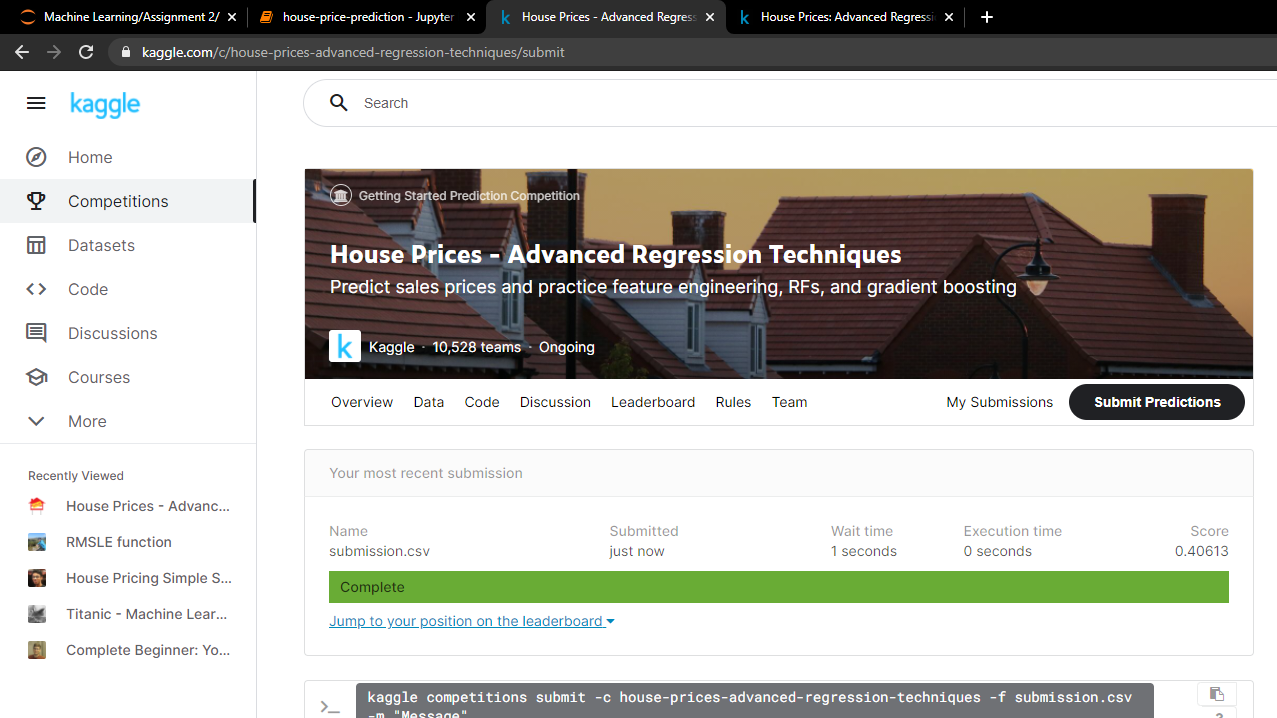

## Dimensionality Reduction using PCA
PCA is a great method for dimensionality reduction. Another good method is feature selection (not shown in this notebook).

In [46]:
pca = PCA(n_components=100)
X_pca = pd.DataFrame(pca.fit_transform(X))

NameError: name 'PCA' is not defined

In [47]:
# Use train_test_split  to split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, train_size=0.70, random_state=1)

NameError: name 'train_test_split' is not defined

In [48]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

NameError: name 'LinearRegression' is not defined

In [49]:
y_pred = linreg.predict(X_test)

NameError: name 'linreg' is not defined

In [50]:
print("Mean Absolute Error", metrics.mean_absolute_error(y_test, y_pred))
print("Mean Sqaured Error", metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("Root Mean Squared Logarithmic Error", np.sqrt(metrics.mean_squared_log_error(y_test, y_pred)))

NameError: name 'metrics' is not defined

In [51]:
test_df = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
print("Shape of test dataset: ", test_df.shape)

FileNotFoundError: [Errno 2] No such file or directory: '../input/house-prices-advanced-regression-techniques/test.csv'

In [52]:
test_df = test_df.reindex(columns = test_df.columns, fill_value=0)
test_df = create_ordinal_encoding(test_df, cols_to_encode)
test_df = impute_missing_values(test_df)
test_df = remove_ID_col(test_df)
test_df = normalize_values(test_df)
test_df = add_interactions(test_df, False)
test_df_pca = pca.transform(test_df)
print("Shape of test dataset: ", test_df_pca.shape)

NameError: name 'test_df' is not defined

In [54]:
# Create submission file
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(linreg.predict(test_df_pca)))
submission.to_csv("submission.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: '../input/house-prices-advanced-regression-techniques/sample_submission.csv'

## Perform PCA provide better accuracy

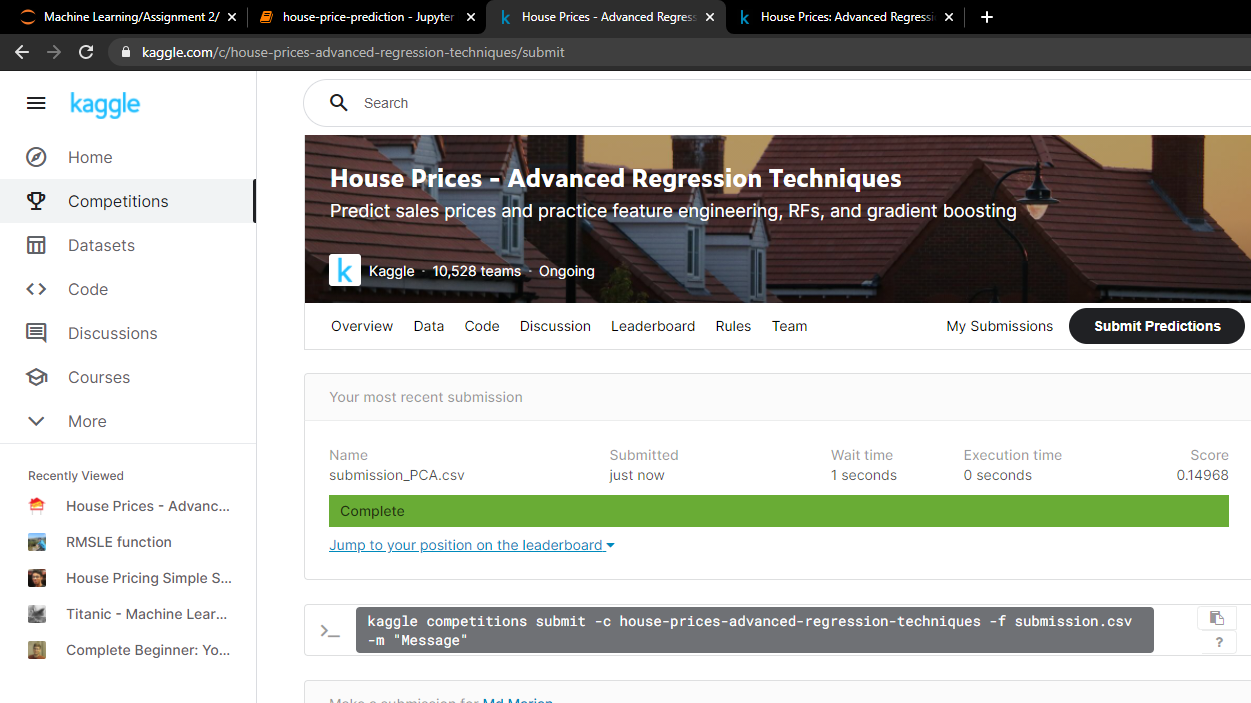

# After performing PCA and Random Forest Algorith, that improves the result.

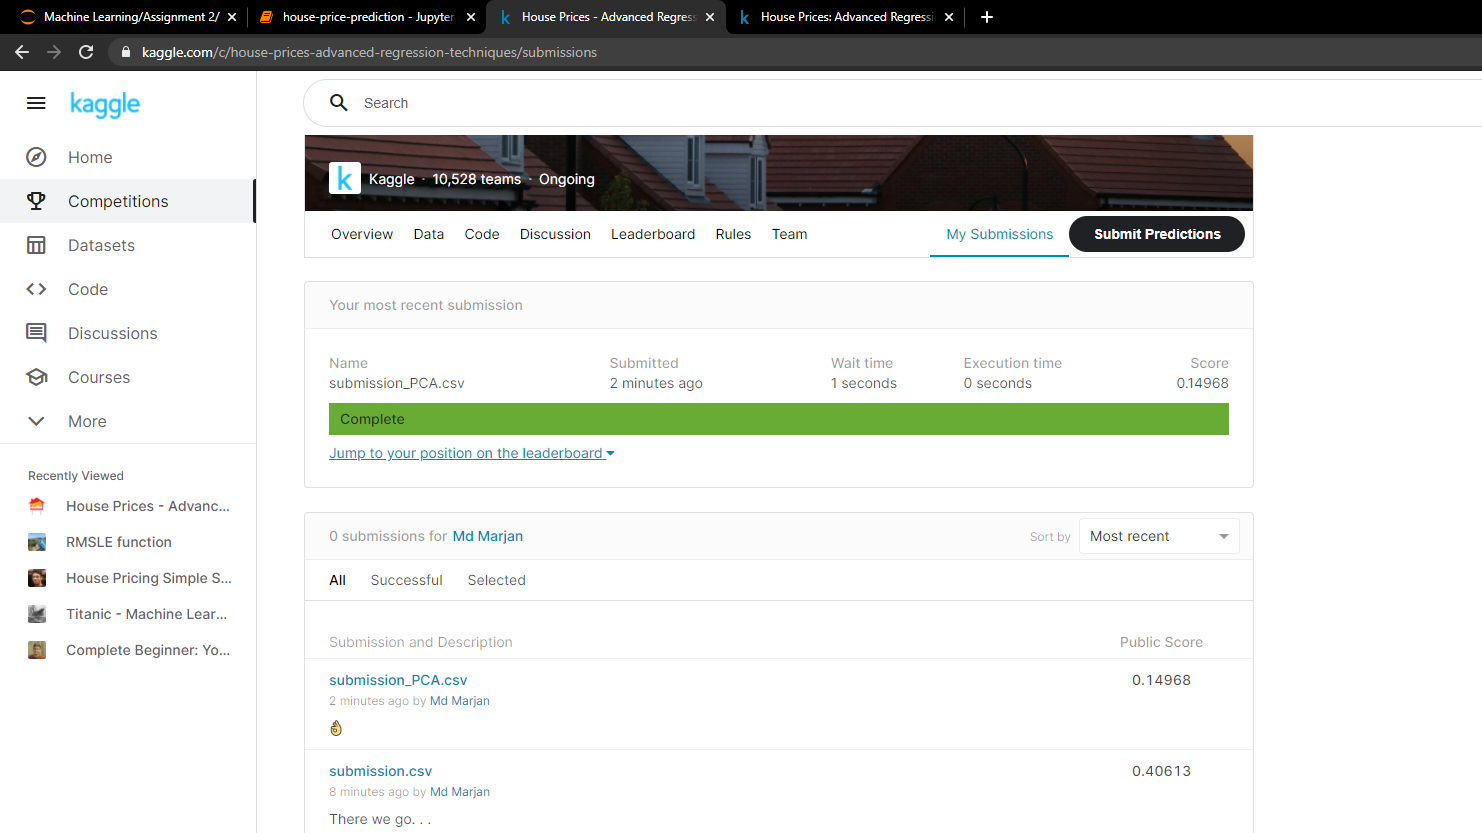